<a href="https://colab.research.google.com/github/MaiAditya/Detecting-Generated-Text----BERT-Model/blob/main/DetectingGeneratedTextUsingBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
df=pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [ ]:
# Load the training and testing datasets
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

In [ ]:
# Explore the training data
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


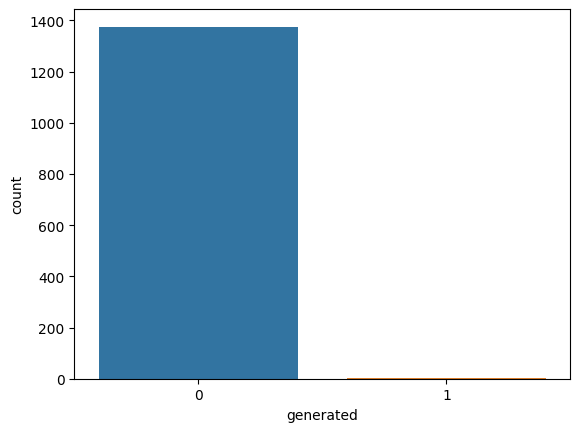

In [ ]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

In [ ]:
test_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Make sure to download the stopwords if you haven't already
# nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Function to clean text by removing punctuation, lowercasing,
    removing non-alphabetic words, and removing stop words.

    Parameters:
    text (str): The input text to be cleaned.

    Returns:
    str: The cleaned text.
    """
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text by splitting into words
    words = text.split()

    # Convert words to lowercase and remove non-alphabetic words
    words = [word.lower() for word in words if word.isalpha()]

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Join the words back into a single string and return
    return ' '.join(words)

# Apply the clean_text function to the 'text' column of the DataFrame
train_essays['clean_text'] = train_essays['text'].apply(clean_text)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.2, random_state=42)

In [ ]:
# Tokenization and Encoding for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

In [ ]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [ ]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
epochs = 15

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss for epoch {epoch+1}: {avg_train_loss:.4f}")


Epoch 1/15: 100%|██████████| 69/69 [01:37<00:00,  1.42s/it, loss=0.000317]


Average training loss for epoch 1: 0.0548


Epoch 2/15: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it, loss=0.000528]


Average training loss for epoch 2: 0.0149


Epoch 3/15: 100%|██████████| 69/69 [01:41<00:00,  1.46s/it, loss=0.00048] 


Average training loss for epoch 3: 0.0109


Epoch 4/15: 100%|██████████| 69/69 [01:41<00:00,  1.47s/it, loss=0.000558]


Average training loss for epoch 4: 0.0112


Epoch 5/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=0.000145]


Average training loss for epoch 5: 0.0049


Epoch 6/15: 100%|██████████| 69/69 [01:41<00:00,  1.46s/it, loss=0.000116]


Average training loss for epoch 6: 0.0013


Epoch 7/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=8.07e-5] 


Average training loss for epoch 7: 0.0002


Epoch 8/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=6.7e-5] 


Average training loss for epoch 8: 0.0001


Epoch 9/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=5.63e-5] 


Average training loss for epoch 9: 0.0001


Epoch 10/15: 100%|██████████| 69/69 [01:41<00:00,  1.46s/it, loss=5.47e-5] 


Average training loss for epoch 10: 0.0001


Epoch 11/15: 100%|██████████| 69/69 [01:41<00:00,  1.46s/it, loss=5.08e-5] 


Average training loss for epoch 11: 0.0001


Epoch 12/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=3.88e-5] 


Average training loss for epoch 12: 0.0000


Epoch 13/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=3.51e-5] 


Average training loss for epoch 13: 0.0000


Epoch 14/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=3.89e-5] 


Average training loss for epoch 14: 0.0000


Epoch 15/15: 100%|██████████| 69/69 [01:40<00:00,  1.46s/it, loss=3.19e-5] 

Average training loss for epoch 15: 0.0000


In [ ]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 1.00


In [ ]:
# Test data processing
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Move input tensor to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

# Generate predictions using your trained model
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits

# Assuming the first column of logits corresponds to the negative class (non-AI-generated)
# and the second column corresponds to the positive class (AI-generated)
predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Move predictions back to CPU

# Create a submission DataFrame with essay IDs and corresponding predictions
submission = pd.DataFrame({
    'id': test_essays['id'],
    'generated': predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('/kaggle/working/submission.csv', index=False)